<h1>Chapter 5 - Text Clustering and Topic Modeling</h1>
<i>Clustering documents using a wide variety of language models.</i>

<a href="https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961"><img src="https://img.shields.io/badge/Buy%20the%20Book!-grey?logo=amazon"></a>
<a href="https://www.oreilly.com/library/view/hands-on-large-language/9781098150952/"><img src="https://img.shields.io/badge/O'Reilly-white.svg?logo=data:image/svg%2bxml;base64,PHN2ZyB3aWR0aD0iMzQiIGhlaWdodD0iMjciIHZpZXdCb3g9IjAgMCAzNCAyNyIgZmlsbD0ibm9uZSIgeG1sbnM9Imh0dHA6Ly93d3cudzMub3JnLzIwMDAvc3ZnIj4KPGNpcmNsZSBjeD0iMTMiIGN5PSIxNCIgcj0iMTEiIHN0cm9rZT0iI0Q0MDEwMSIgc3Ryb2tlLXdpZHRoPSI0Ii8+CjxjaXJjbGUgY3g9IjMwLjUiIGN5PSIzLjUiIHI9IjMuNSIgZmlsbD0iI0Q0MDEwMSIvPgo8L3N2Zz4K"></a>
<a href="https://github.com/HandsOnLLM/Hands-On-Large-Language-Models"><img src="https://img.shields.io/badge/GitHub%20Repository-black?logo=github"></a>
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HandsOnLLM/Hands-On-Large-Language-Models/blob/main/chapter05/Chapter%205%20-%20Text%20Clustering%20and%20Topic%20Modeling.ipynb)

---

This notebook is for Chapter 5 of the [Hands-On Large Language Models](https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961) book by [Jay Alammar](https://www.linkedin.com/in/jalammar) and [Maarten Grootendorst](https://www.linkedin.com/in/mgrootendorst/).

---

<a href="https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961">
<img src="https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/images/book_cover.png" width="350"/></a>


### [OPTIONAL] - Installing Packages on <img src="https://colab.google/static/images/icons/colab.png" width=100>

If you are viewing this notebook on Google Colab (or any other cloud vendor), you need to **uncomment and run** the following codeblock to install the dependencies for this chapter:

---

💡 **NOTE**: We will want to use a GPU to run the examples in this notebook. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---


In [1]:
%%capture
!pip install bertopic openai datamapplot

# **ArXiv Articles: Computation and Language**

In [2]:
%%capture
!pip install -U datasets fsspec huggingface_hub

In [ ]:
# Load data from huggingface
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

# Extract metadata
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

In [7]:
titles[0]
abstracts[0]

'  In this paper Arabic was investigated from the speech recognition problem\npoint of view. We propose a novel approach to build an Arabic Automated Speech\nRecognition System (ASR). This system is based on the open source CMU Sphinx-4,\nfrom the Carnegie Mellon University. CMU Sphinx is a large-vocabulary;\nspeaker-independent, continuous speech recognition system based on discrete\nHidden Markov Models (HMMs). We build a model using utilities from the\nOpenSource CMU Sphinx. We will demonstrate the possible adaptability of this\nsystem to Arabic voice recognition.\n'

# **A Common Pipeline for Text Clustering**

## **1. Embedding Documents**

In [ ]:
from sentence_transformers import SentenceTransformer

# Create an embedding for each abstract
# 'thenlper' embeddings capture the semantic meaning of the text, allowing for tasks like clustering and topic modeling based on the content of the documents.

embedding_model = SentenceTransformer('thenlper/gte-small')
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

In [9]:
# Check the dimensions of the resulting embeddings
embeddings.shape

(44949, 384)

## **2. Reducing the Dimensionality of Embeddings**

In [10]:
from umap import UMAP

# We reduce the input embeddings from 384 dimenions to 5 dimensions
# dimensions are the number of features or attributes that are used to represent each data point
#  Each dimension in the embedding vector represents a learned feature of the text that captures some aspect of its meaning or context.
# The model learns to represent words and sentences as points in this multi-dimensional space, where the distance and direction between points reflect their semantic relationships.
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## **3. Cluster the Reduced Embeddings**

In [ ]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric='euclidean', cluster_selection_method='eom'
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))

## **Inspecting the Clusters**

Manually inspect the first three documents in cluster 0:

In [12]:
import numpy as np

# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



Next, we reduce our embeddings to 2-dimensions so that we can plot them and get a rough understanding of the generated clusters.

In [13]:
import pandas as pd

# Reduce 384-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric='cosine', random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Static Plot

(np.float64(-7.282655382156372),
 np.float64(11.277046823501587),
 np.float64(-6.28760678768158),
 np.float64(10.93724067211151))

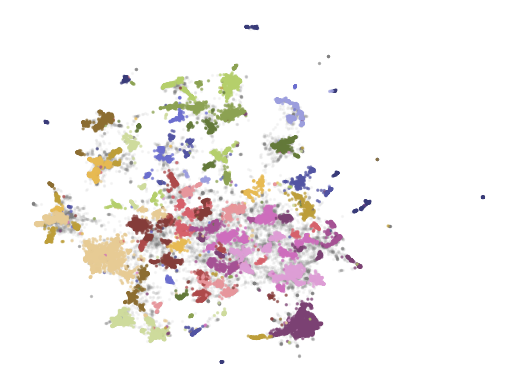

In [14]:
import matplotlib.pyplot as plt

# Plot outliers and non-outliers seperately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap='tab20b'
)
plt.axis('off')
# plt.savefig("matplotlib.png", dpi=300)  # Uncomment to save the graph as a .png

# From Text Clustering to Topic Modeling

## **BERTopic: A Modular Topic Modeling Framework**

In [15]:
from bertopic import BERTopic

# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2025-07-08 15:17:09,963 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-08 15:18:02,509 - BERTopic - Dimensionality - Completed ✓
2025-07-08 15:18:02,511 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-08 15:18:04,658 - BERTopic - Cluster - Completed ✓
2025-07-08 15:18:04,677 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-08 15:18:08,629 - BERTopic - Representation - Completed ✓


Now, let's start exploring the topics that we got by running the code above.

In [16]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0       -1  14830                               -1_the_of_and_to   
1        0   2203                 0_question_qa_answer_questions   
2        1   1972                   1_speech_asr_recognition_end   
3        2    859              2_hate_offensive_speech_detection   
4        3    848  3_summarization_summaries_summary_abstractive   
..     ...    ...                                            ...   
150    149     53           149_counseling_mental_therapy_health   
151    150     53                150_mixed_code_sentiment_mixing   
152    151     53      151_prompt_prompts_optimization_prompting   
153    152     50                 152_long_context_window_length   
154    153     50                     153_chatgpt_its_openai_has   

                                        Representation  \
0    [the, of, and, to, in, we, for, language, that...   
1    [question, qa, answer, questions, answering, a...   
2    [speech, asr, recognition, end, acoustic, spea...   
3    [hate, offensive, speech, detection, toxic, so...   
4    [summarization, summaries, summary, abstractiv...   
..                                                 ...   
150  [counseling, mental, therapy, health, psychoth...   
151  [mixed, code, sentiment, mixing, english, anal...   
152  [prompt, prompts, optimization, prompting, llm...   
153  [long, context, window, length, llms, contexts...   
154  [chatgpt, its, openai, has, ai, tasks, respons...   

                                   Representative_Docs  
0    [  Word Representations form the core componen...  
1    [  With the development of deep learning techn...  
2    [  End-to-end Speech Translation (ST) models h...  
3    [  With growing role of social media in shapin...  
4    [  Pre-trained neural abstractive summarizatio...  
..                                                 ...  
150  [  Mental health care poses an increasingly se...  
151  [  The usage of more than one language in the ...  
152  [  Prompt optimization aims to find the best p...  
153  [  Extending the context window of large langu...  
154  [  Recently, ChatGPT has attracted great atten...  

[155 rows x 5 columns]

Hundreds of topics were generated using the default model! To get the top 10 keywords per topic as well as their c-TF-IDF weights, we can use the `get_topic()` function:

In [17]:
topic_model.get_topic(0)

[('question', np.float64(0.021513659402328498)),
 ('qa', np.float64(0.01599542005307066)),
 ('answer', np.float64(0.01598355249769436)),
 ('questions', np.float64(0.015939920753689895)),
 ('answering', np.float64(0.015001840362609379)),
 ('answers', np.float64(0.009914565594237793)),
 ('retrieval', np.float64(0.009494874277091257)),
 ('comprehension', np.float64(0.007755949913161138)),
 ('reading', np.float64(0.0072157025360459525)),
 ('knowledge', np.float64(0.006384494984848137))]

We can use the `find_topics()` function to search for specific topics based on a search term. Let’s search for a topic about topic modeling:

In [18]:
topic_model.find_topics("topic modeling")

([26, -1, 47, 34, 112],
 [np.float32(0.9548121),
  np.float32(0.9118329),
  np.float32(0.90837073),
  np.float32(0.90527934),
  np.float32(0.9039324)])

It returns that topic 22 has a relatively high similarity (0.95) with our search term. If we then inspect the topic, we can see that it is indeed a topic about topic modeling:

In [19]:
topic_model.get_topic(22)

[('classification', np.float64(0.027700659966214014)),
 ('label', np.float64(0.027298282460681503)),
 ('labels', np.float64(0.017843140375134993)),
 ('text', np.float64(0.01573274215114283)),
 ('hierarchical', np.float64(0.009962405511364982)),
 ('document', np.float64(0.008967767600591724)),
 ('class', np.float64(0.008105128616428021)),
 ('documents', np.float64(0.0077769277051026025)),
 ('hierarchy', np.float64(0.007529893215227781)),
 ('multi', np.float64(0.006948802731317293))]

That seems like a topic that is, in part, characterized by the classic LDA technique. Let's see if the BERTopic paper was also assigned to topic 22:

In [20]:
topic_model.topics_[titles.index('BERTopic: Neural topic modeling with a class-based TF-IDF procedure')]

26

It is! We expected it might be because there are non-LDA specific words in the topic describtion such as "clustering" and "topic".

### **Visualizations**

**Visualize Documents**

In [23]:
# Visualize topics and documents
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))

In [24]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

# Visualize relationships between topics
topic_model.visualize_heatmap(n_clusters=30)

# Visualize the potential hierarchical structure of topics
topic_model.visualize_hierarchy()

## **Representation Models**

In these examples that follow, we will update our topic representations **after** having trained our model. This allows for quick iteration. If, however, you want to use a representation model at the start of training, you will need to run it as follows:

```python
from bertopic.representation import KeyBERTInspired
from bertopic import BERTopic

# Create your representation model
representation_model = KeyBERTInspired()

# Use the representation model in BERTopic on top of the default pipeline
topic_model = BERTopic(representation_model=representation_model)
```

To use the representation models, we are first going to duplicate our topic model such that easily show the differences between a model with and without representation model.

In [25]:
# Save original representations
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [26]:
def topic_differences(model, original_topics, nr_topics=5):
    """Show the differences in topic representations between two models """
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):

        # Extract top 5 words per topic per model
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

### KeyBERTInspired

In [27]:
from bertopic.representation import KeyBERTInspired

# Update our topic representations using KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | qa | answer | questions | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2      hate | offensive | speech | detection | toxic   
3      3  summarization | summaries | summary | abstract...   
4      4      gender | bias | biases | debiasing | fairness   

                                             Updated  
0  questions | answering | comprehension | questi...  
1  translation | speech | transcription | phoneti...  
2  hate | hateful | language | classifiers | twitter  
3  summarization | summarizers | summaries | summ...  
4         gender | gendered | bias | biases | biased

### Maximal Marginal Relevance

In [28]:
from bertopic.representation import MaximalMarginalRelevance

# Update our topic representations to MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | qa | answer | questions | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2      hate | offensive | speech | detection | toxic   
3      3  summarization | summaries | summary | abstract...   
4      4      gender | bias | biases | debiasing | fairness   

                                             Updated  
0  questions | retrieval | comprehension | knowle...  
1        speech | asr | model | automatic | training  
2       hate | toxic | social | comments | platforms  
3  summarization | extractive | factual | sentenc...  
4  gender | bias | fairness | stereotypes | embed...

## Text Generation



### Flan-T5

In [ ]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

# Update our topic representations using Flan-T5
generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

### OpenAI

In [ ]:
import openai
from bertopic.representation import OpenAI

prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format:
topic: <short topic label>
"""

# Update our topic representations using GPT-3.5
client = openai.OpenAI(api_key="YOUR_KEY_HERE")
representation_model = OpenAI(
    client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

100%|██████████| 156/156 [02:13<00:00,  1.17it/s]


Topic                                           Original  \
0      0        speech | asr | recognition | end | acoustic   
1      1  medical | clinical | biomedical | patient | he...   
2      2  sentiment | aspect | analysis | reviews | opinion   
3      3        translation | nmt | machine | neural | bleu   
4      4  summarization | summaries | summary | abstract...   

                                             Updated  
0  Leveraging External Data for Improving Low-Res...  
1  Improved Representation Learning for Biomedica...  
2  "Advancements in Aspect-Based Sentiment Analys...  
3            Neural Machine Translation Enhancements  
4                  Document Summarization Techniques

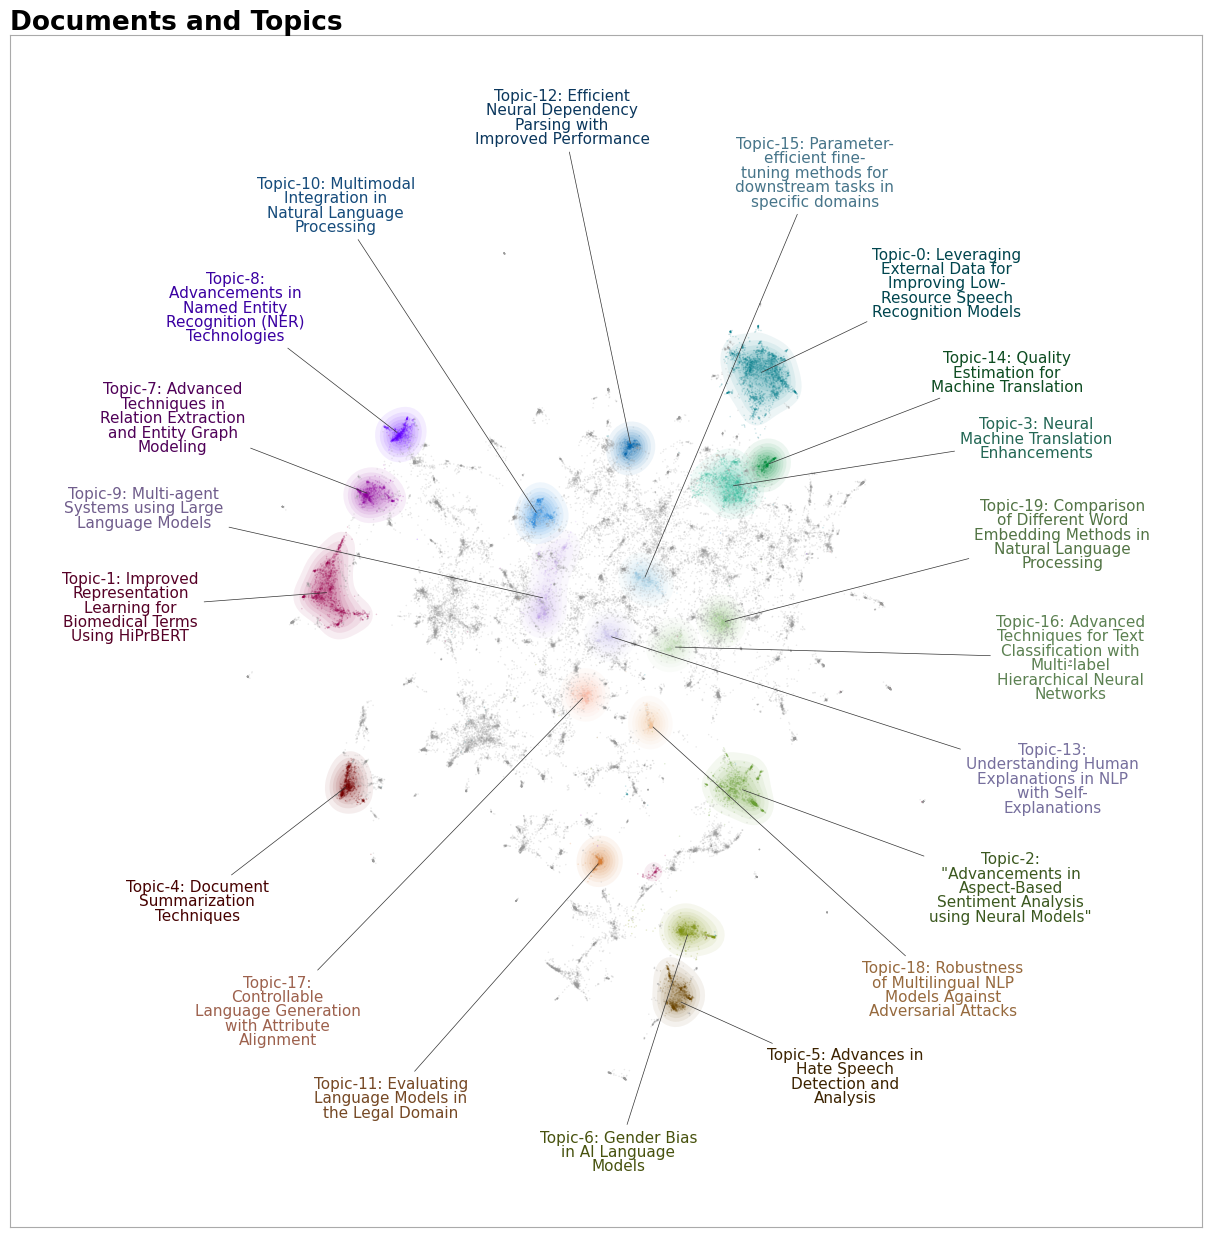

In [ ]:
# Visualize topics and documents
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings,
    width=1200,
    label_font_size=11,
    label_wrap_width=20,
    use_medoids=True,
)
plt.savefig("datamapplot.png", dpi=300)


## **BONUS**: Word Cloud

Make sure to pip install `wordcloud` first in order to follow this bonus:


First, we need to make sure that each topic is described by a bit more words than just 10 as that would make for a much more interesting wordcloud.

In [33]:
topic_model.update_topics(abstracts, top_n_words=500)

2025-07-08 16:16:02,123 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Then, we can run the following code to generate the wordcloud for our topic modeling topic:

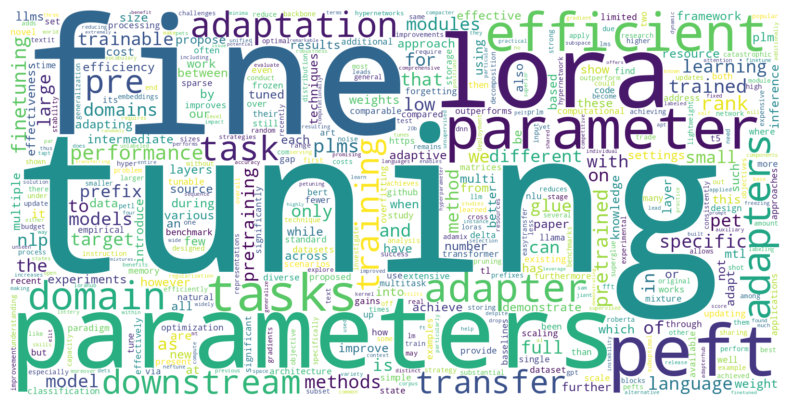

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt0

def create_wordcloud(model, topic):
    plt.figure(figsize=(10,5))
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000, width=1600, height=800)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=17)